In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 18})
sns.set_style("darkgrid")

# EDA & Data Preprocessing
In this notebook, we're going to carry out a few EDA operations to get acquainted with the data set of the challenge. We will analyze the 7 features and their relationships, generate new derived features and justify the representativeness of a 10% subsample on the basis of faster subsequent training.

## Dataframes creation

In [37]:
df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
df_y = pd.read_csv('../dataset/y_train.csv').drop(columns=['id'])
df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)
df_x.describe()

,trq_measured,oat,mgt,pa,ias,np,ng
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281
std,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084
min,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830
25%,56.100000,7.500000,562.400000,135.331200,51.125000,95.330000,92.226440
50%,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000
75%,75.500000,18.500000,622.300000,588.264000,110.562500,100.020000,99.900000
max,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000


## Explorative Data Analysis
### Skewness study

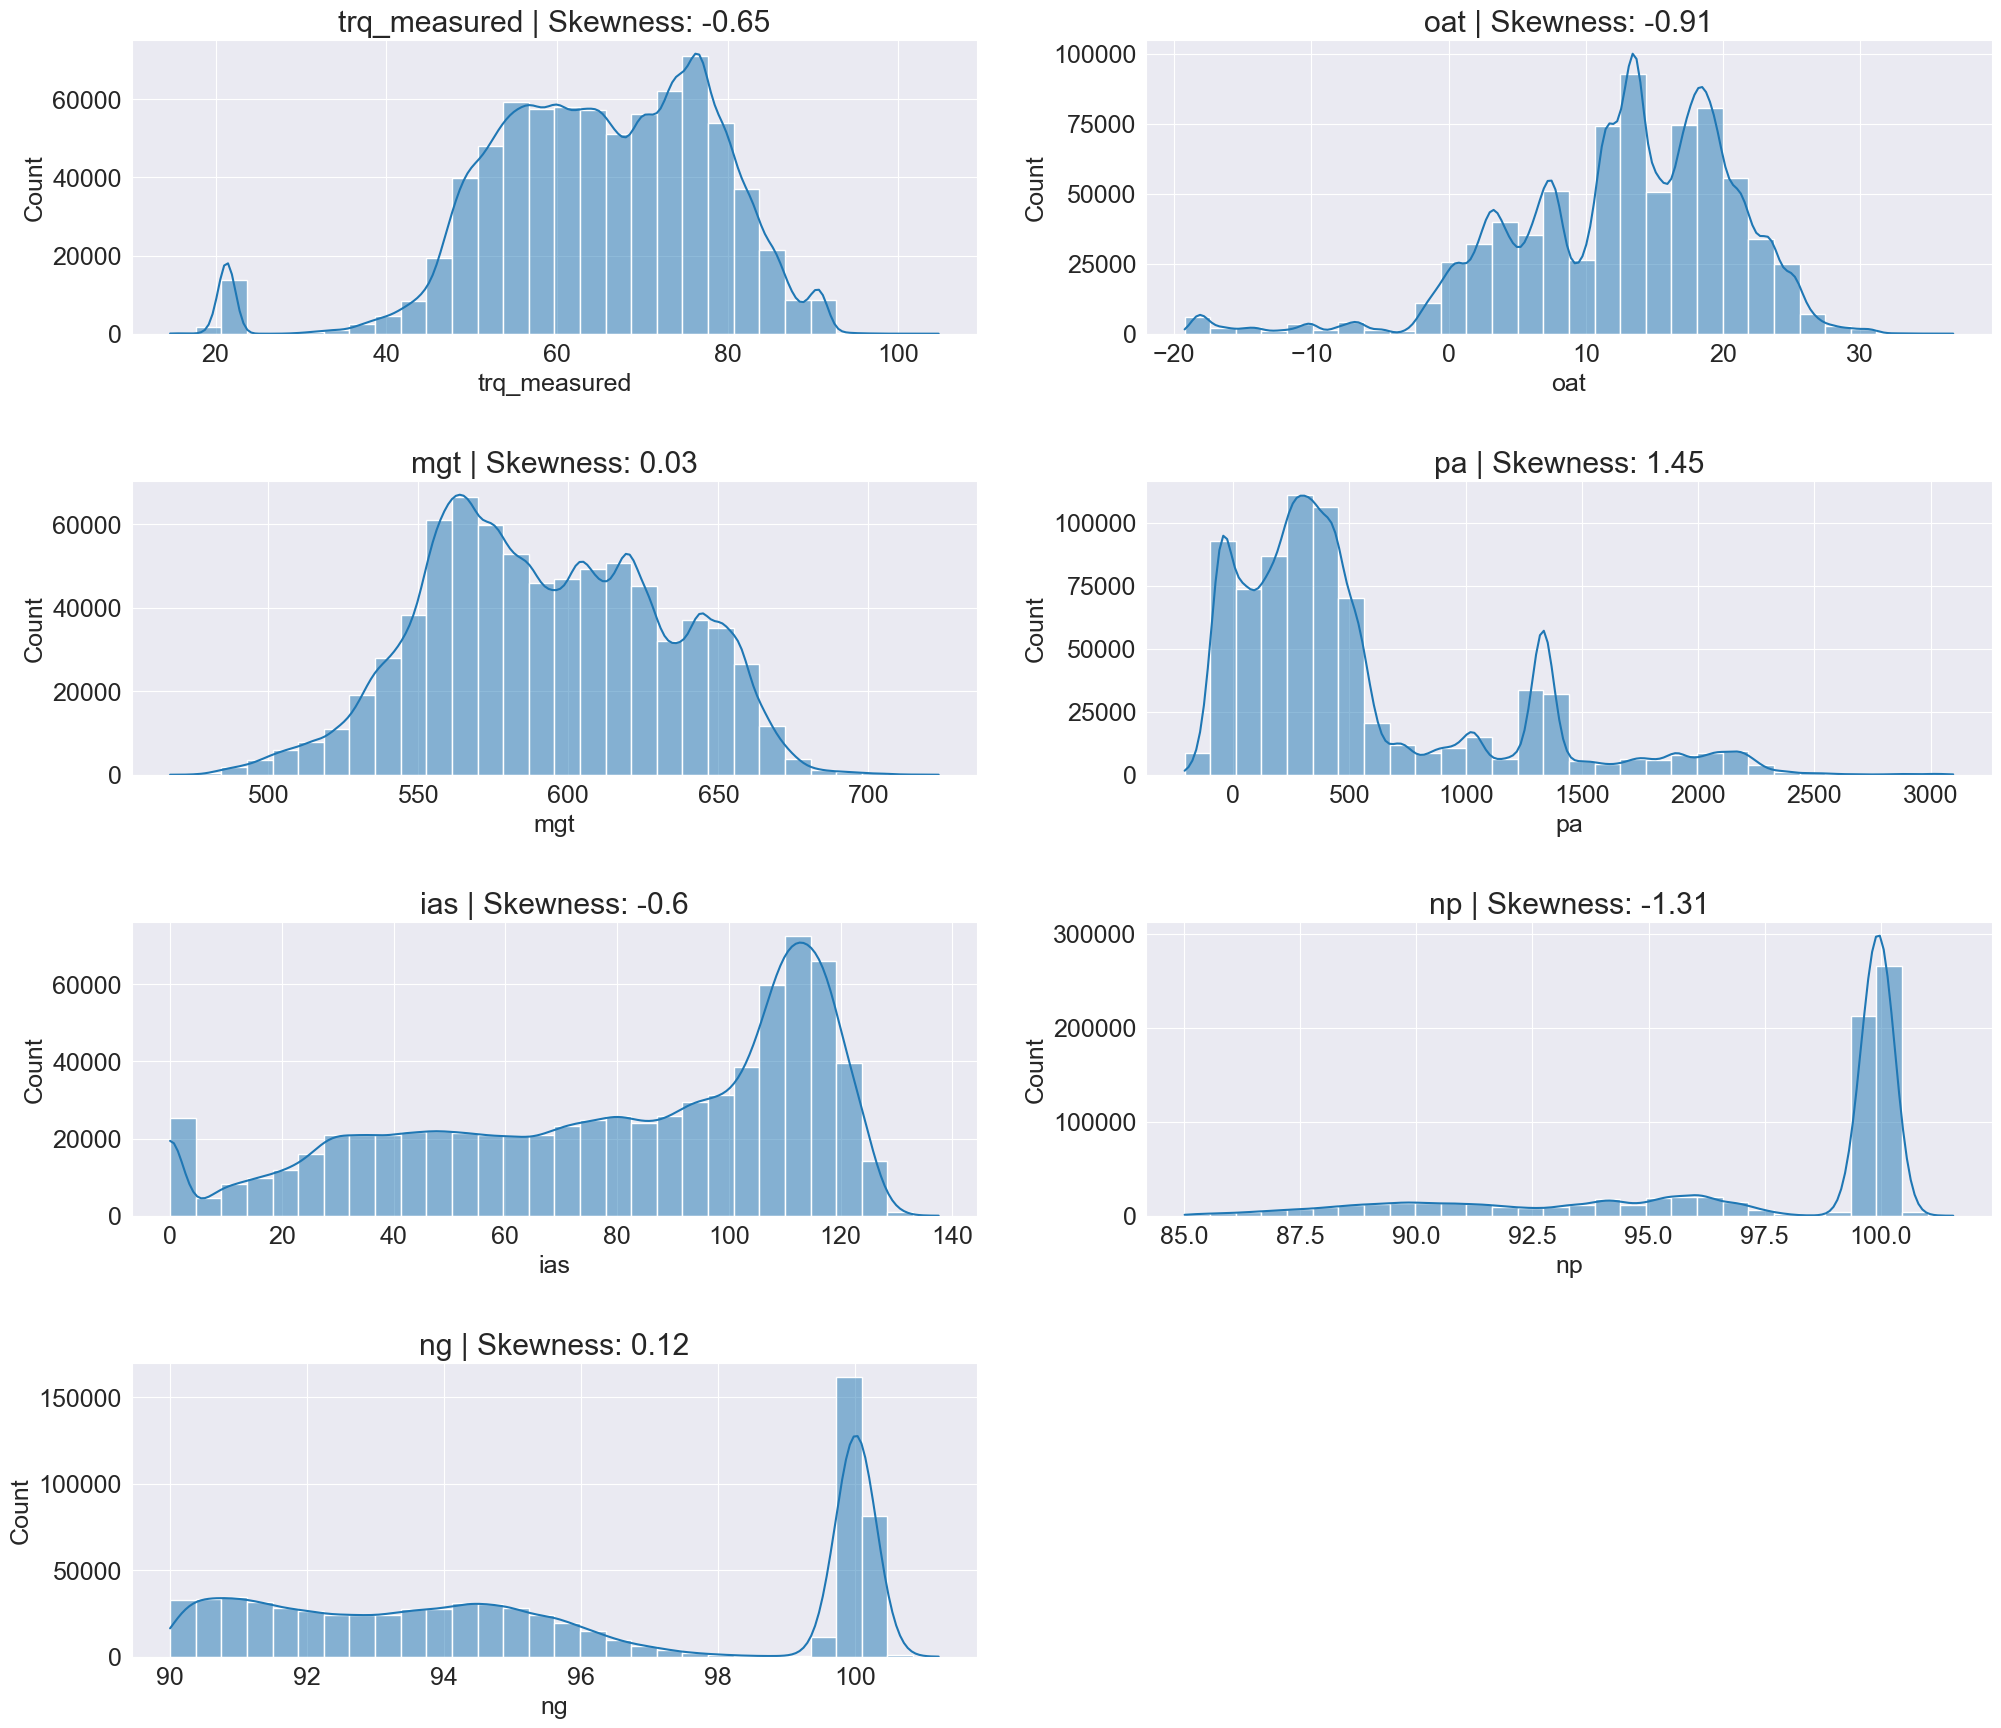

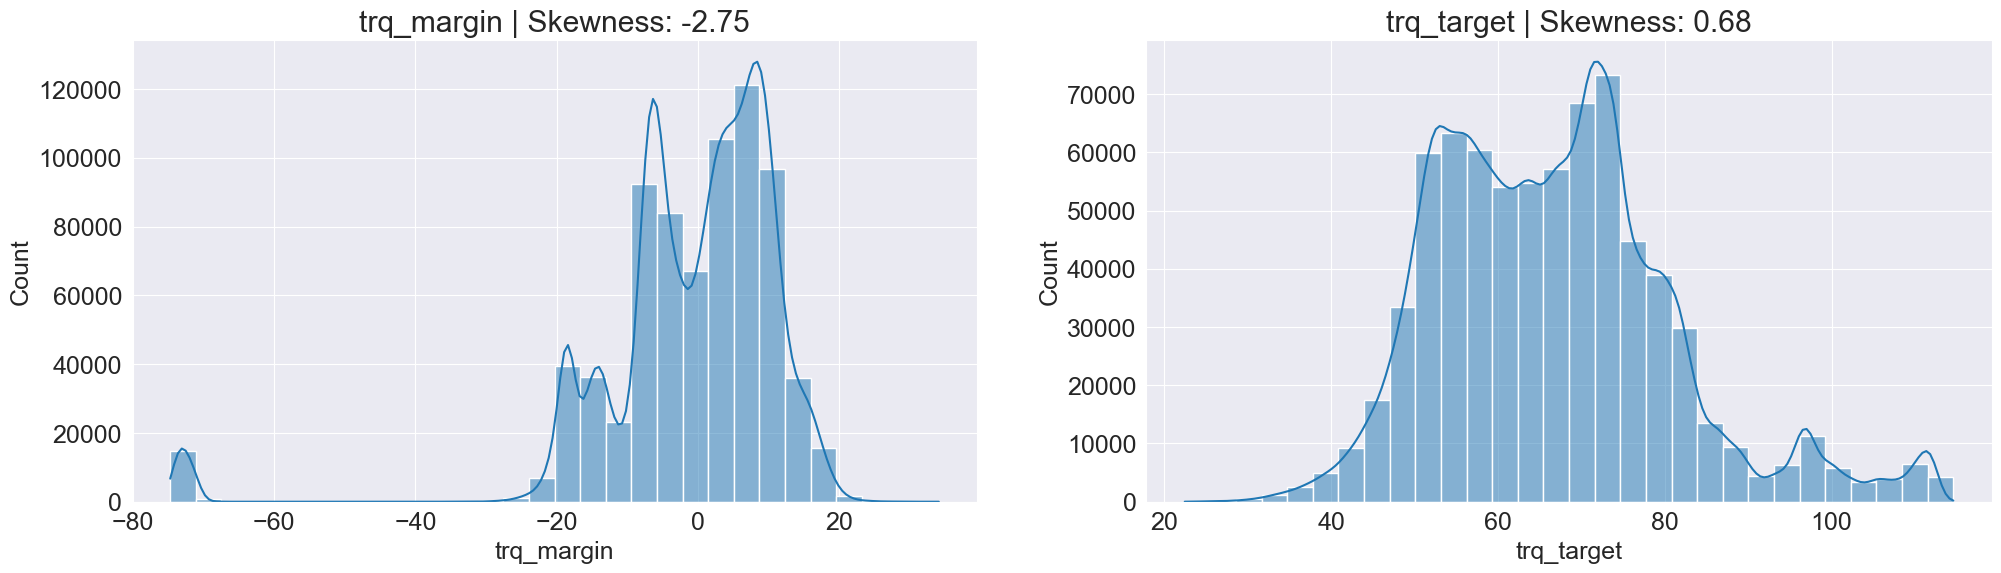

In [14]:
### PLOT FEATURES ###
num_x_features = len(df_x.columns)
plt.figure(figsize=(24, num_x_features * 3))
for idx, feature in enumerate(df_x.columns,1):
    plt.subplot((num_x_features + 1) // 2, 2, idx)
    sns.histplot(df_x[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_x[feature].skew(), 2)}")

plt.subplots_adjust(hspace=0.5)

### PLOT Y_TRAIN FEATURES ###
num_y_features = 2
plt.figure(figsize=(24, num_y_features * 3))
for idx, feature in enumerate(['trq_margin','trq_target'], 1):
    plt.subplot((num_y_features + 1) // 2, 2, idx)
    sns.histplot(df_y[feature], kde=True, bins=30)
    plt.title(f"{feature} | Skewness: {round(df_y[feature].skew(), 2)}")

# plt.tight_layout()
plt.show()

The features in this dataset that have skewness – exactly 0 depicts the symmetrical distribution and the plots with skewness 1 or above 1 is positively or right skewd distribution. In right skewd or positively skewed distribution if the tail is more on the right side, that indicates extremely high values.

### Faulty distributions

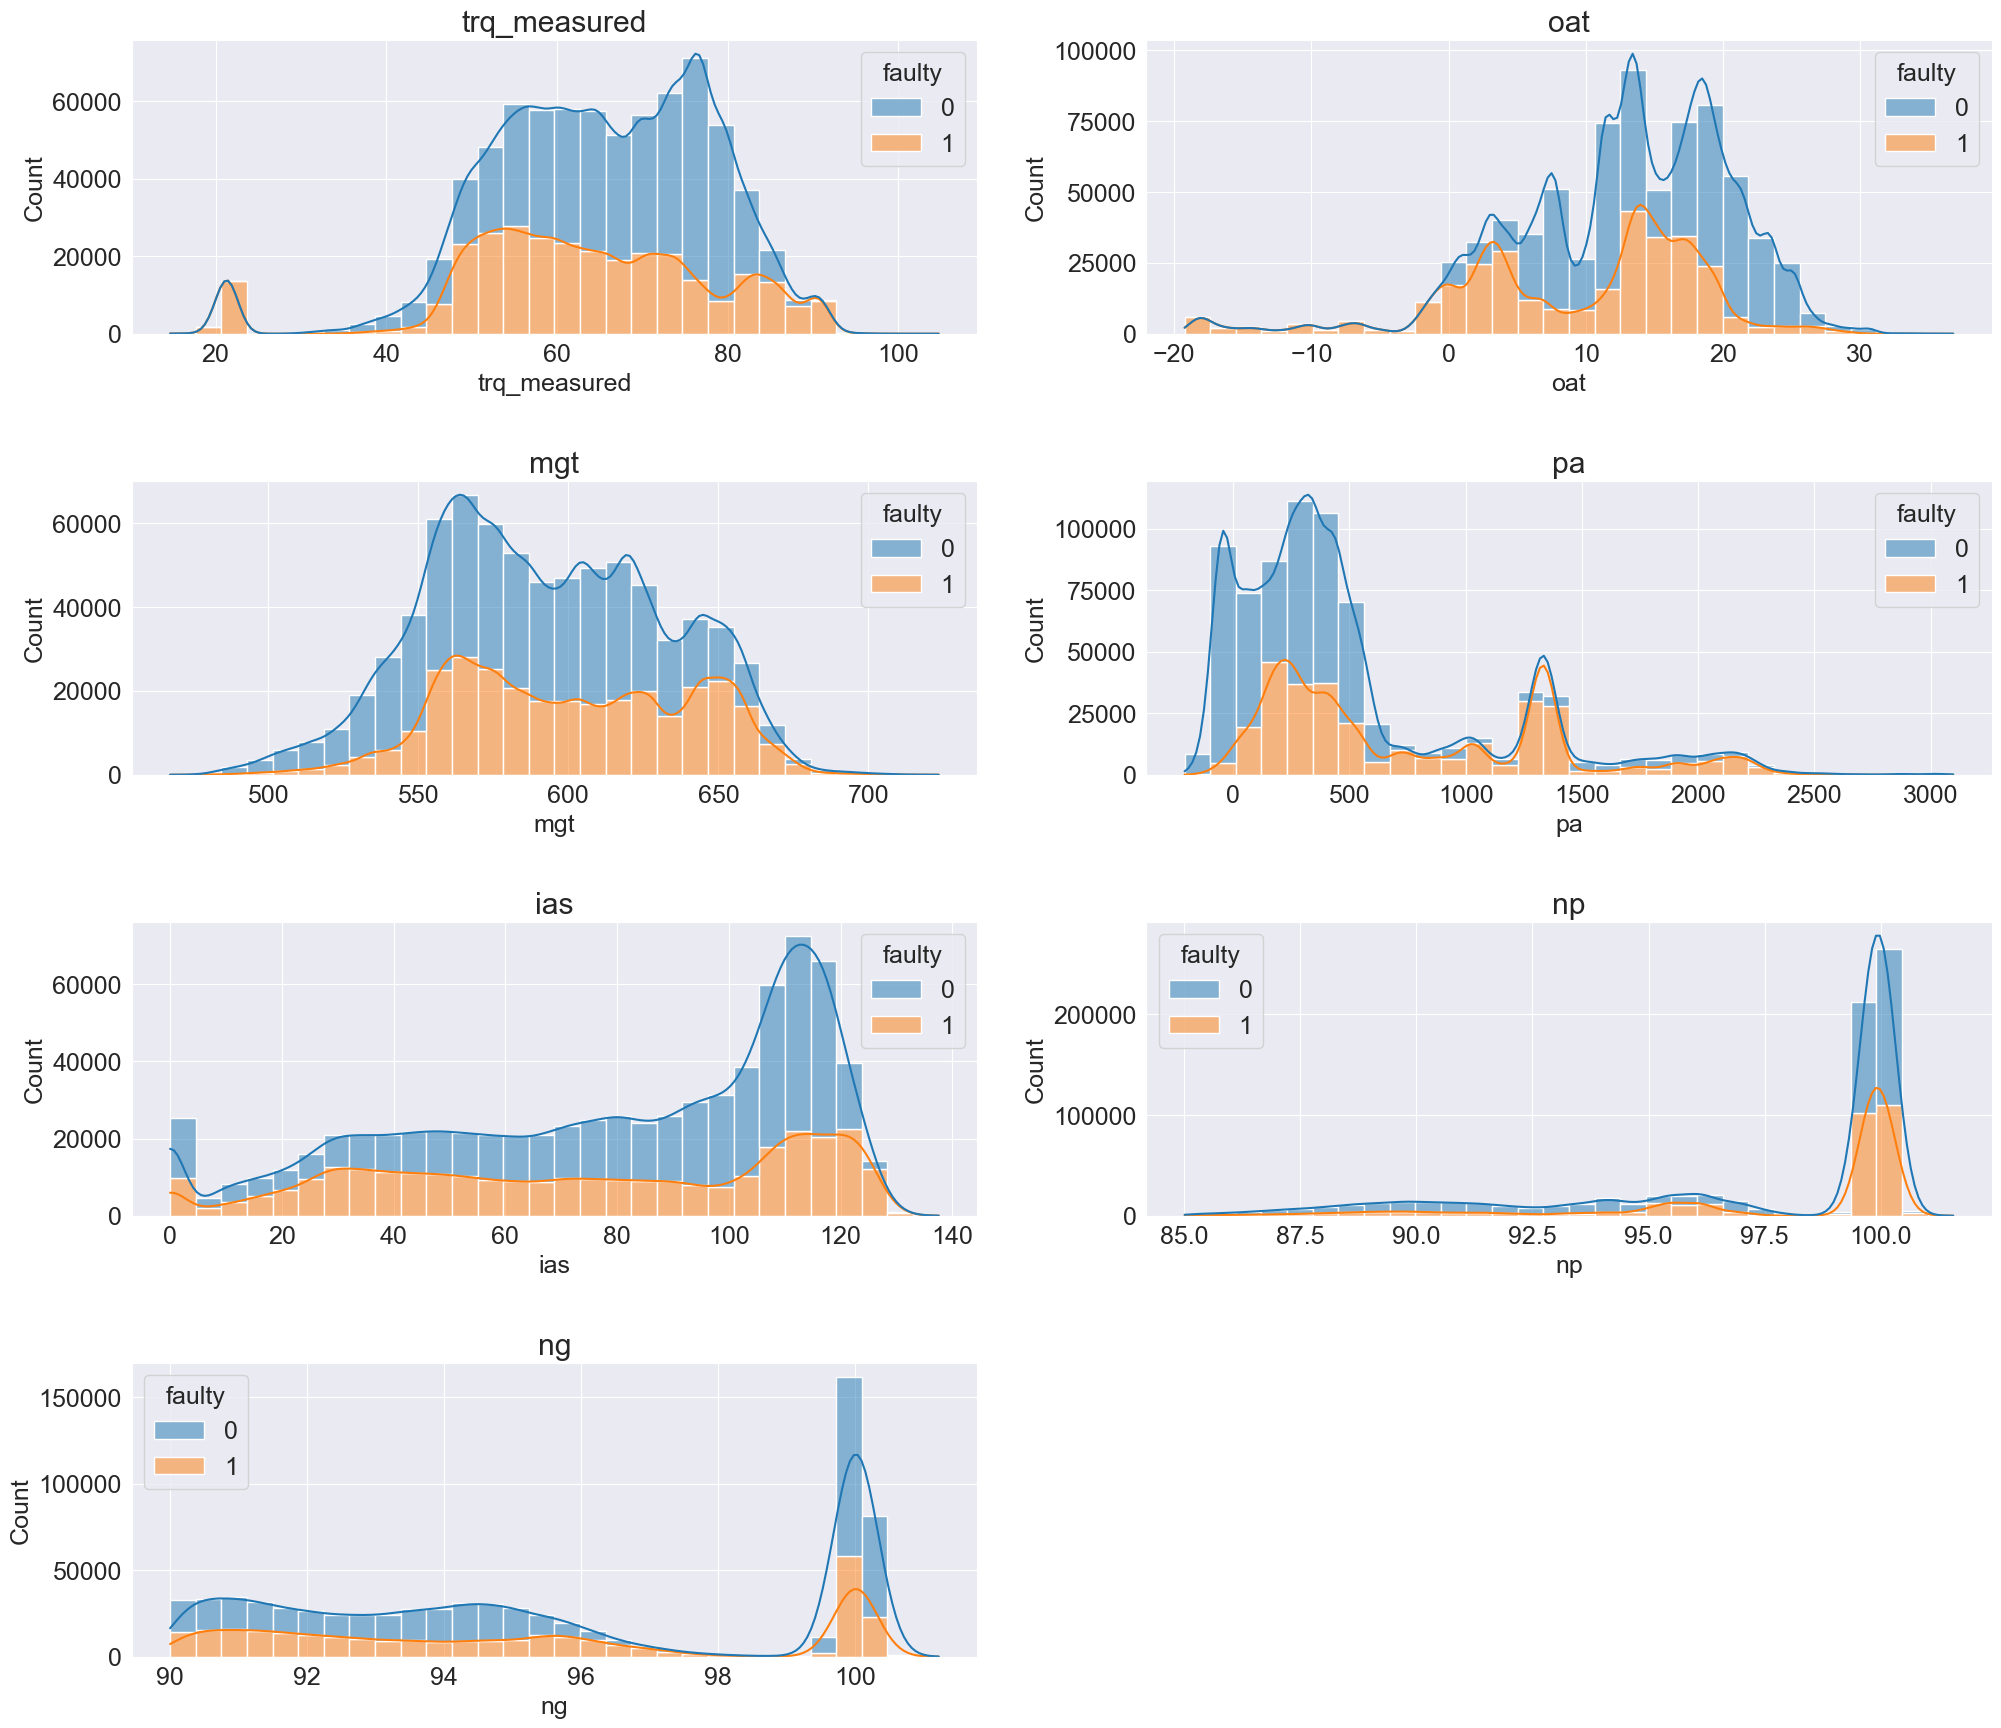

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

### PLOT FEATURES BY FAULTY CLASS LABEL ###
num_x_features = len(df_x.columns)
plt.figure(figsize=(24, num_x_features * 3))

for idx, feature in enumerate(df_x.columns, 1):
    plt.subplot((num_x_features + 1) // 2, 2, idx)
    sns.histplot(data=df_x, x=feature, hue=df_y["faulty"], kde=True, bins=30, palette="tab10", multiple="stack")
    plt.title(f"{feature}")

plt.subplots_adjust(hspace=0.5)
plt.show()


### Feature eptagram

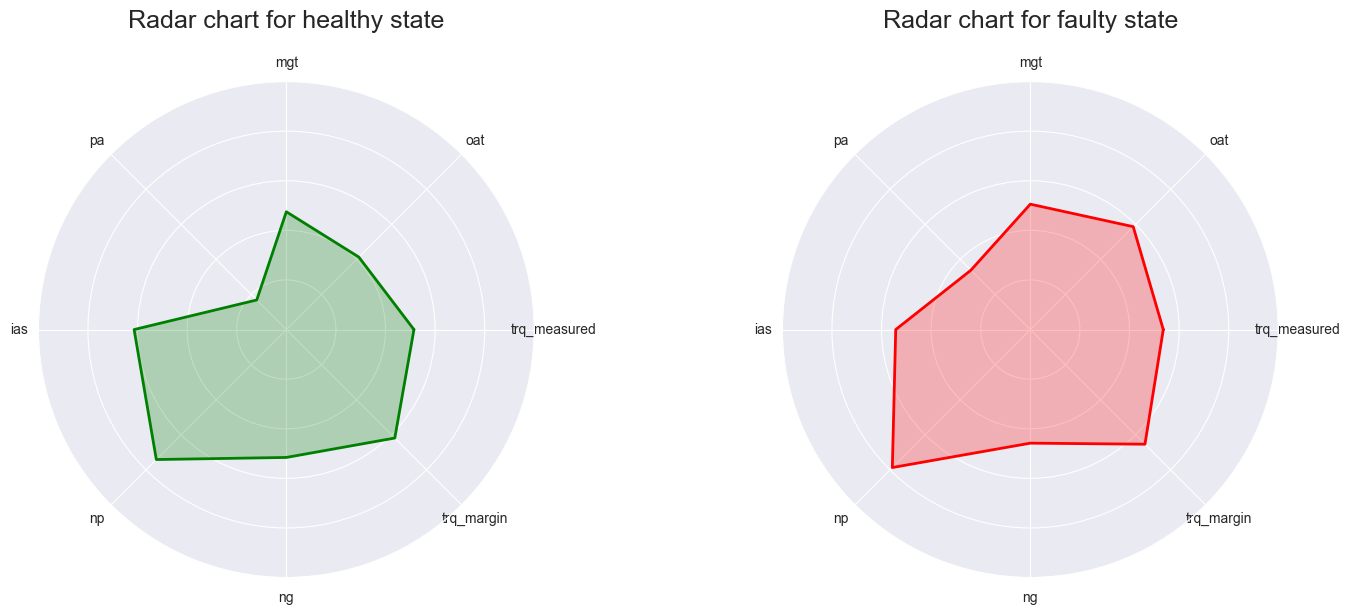

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Merge df_x (features) and df_y (labels) if necessary
# ----------------------------------------------------------------------
train_data = pd.concat([df_x, df_y], axis=1)

# Remove the 'id' column if present
if 'id' in train_data.columns:
    train_data = train_data.drop(['id'], axis=1)

# ----------------------------------------------------------------------
# 2. Remove 'trq_target' from the dataset
# ----------------------------------------------------------------------
if 'trq_target' in train_data.columns:
    train_data = train_data.drop(['trq_target'], axis=1)

# ----------------------------------------------------------------------
# 3. Split data into healthy (faulty == 0) and faulty (faulty == 1) subsets
# ----------------------------------------------------------------------
X_train_healthy = train_data[train_data['faulty'] == 0].drop('faulty', axis=1)
X_train_faulty = train_data[train_data['faulty'] == 1].drop('faulty', axis=1)

# ----------------------------------------------------------------------
# 4. Min-Max scaling: Normalize all features between 0 and 1
# ----------------------------------------------------------------------
def min_max_scale(df):
    return (df - df.min()) / (df.max() - df.min())

X_train_healthy_scaled = min_max_scale(X_train_healthy)
X_train_faulty_scaled = min_max_scale(X_train_faulty)

# Compute the mean value of each feature for both groups
mean_features_healthy = X_train_healthy_scaled.mean()
mean_features_faulty = X_train_faulty_scaled.mean()

labels = mean_features_healthy.index
values_healthy = mean_features_healthy.values
values_faulty = mean_features_faulty.values

# ----------------------------------------------------------------------
# 5. Prepare data for radar charts
# ----------------------------------------------------------------------
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the loop for radar charts
values_healthy = np.concatenate((values_healthy, [values_healthy[0]]))
values_faulty = np.concatenate((values_faulty, [values_faulty[0]]))
angles += angles[:1]

# ----------------------------------------------------------------------
# 6. Adjust figure size dynamically based on the number of features
# ----------------------------------------------------------------------
fig_size = (min(2 * num_vars, 18), min(2 * num_vars, 9))
fig, axs = plt.subplots(1, 2, figsize=fig_size, subplot_kw=dict(polar=True))

# Radar chart for healthy state
axs[0].fill(angles, values_healthy, color='g', alpha=0.25)
axs[0].plot(angles, values_healthy, color='g', linewidth=2)
axs[0].set_yticklabels([])
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(labels, fontsize=10)
axs[0].set_title("Radar chart for healthy state", size=18, pad=20)
axs[0].set_ylim(0, 1)  # Keep scale between 0 and 1

# Radar chart for faulty state
axs[1].fill(angles, values_faulty, color='r', alpha=0.25)
axs[1].plot(angles, values_faulty, color='r', linewidth=2)
axs[1].set_yticklabels([])
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(labels, fontsize=10)
axs[1].set_title("Radar chart for faulty state", size=18, pad=20)
axs[1].set_ylim(0, 1)  # Keep scale between 0 and 1

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.5)

plt.show()


### Correlation study

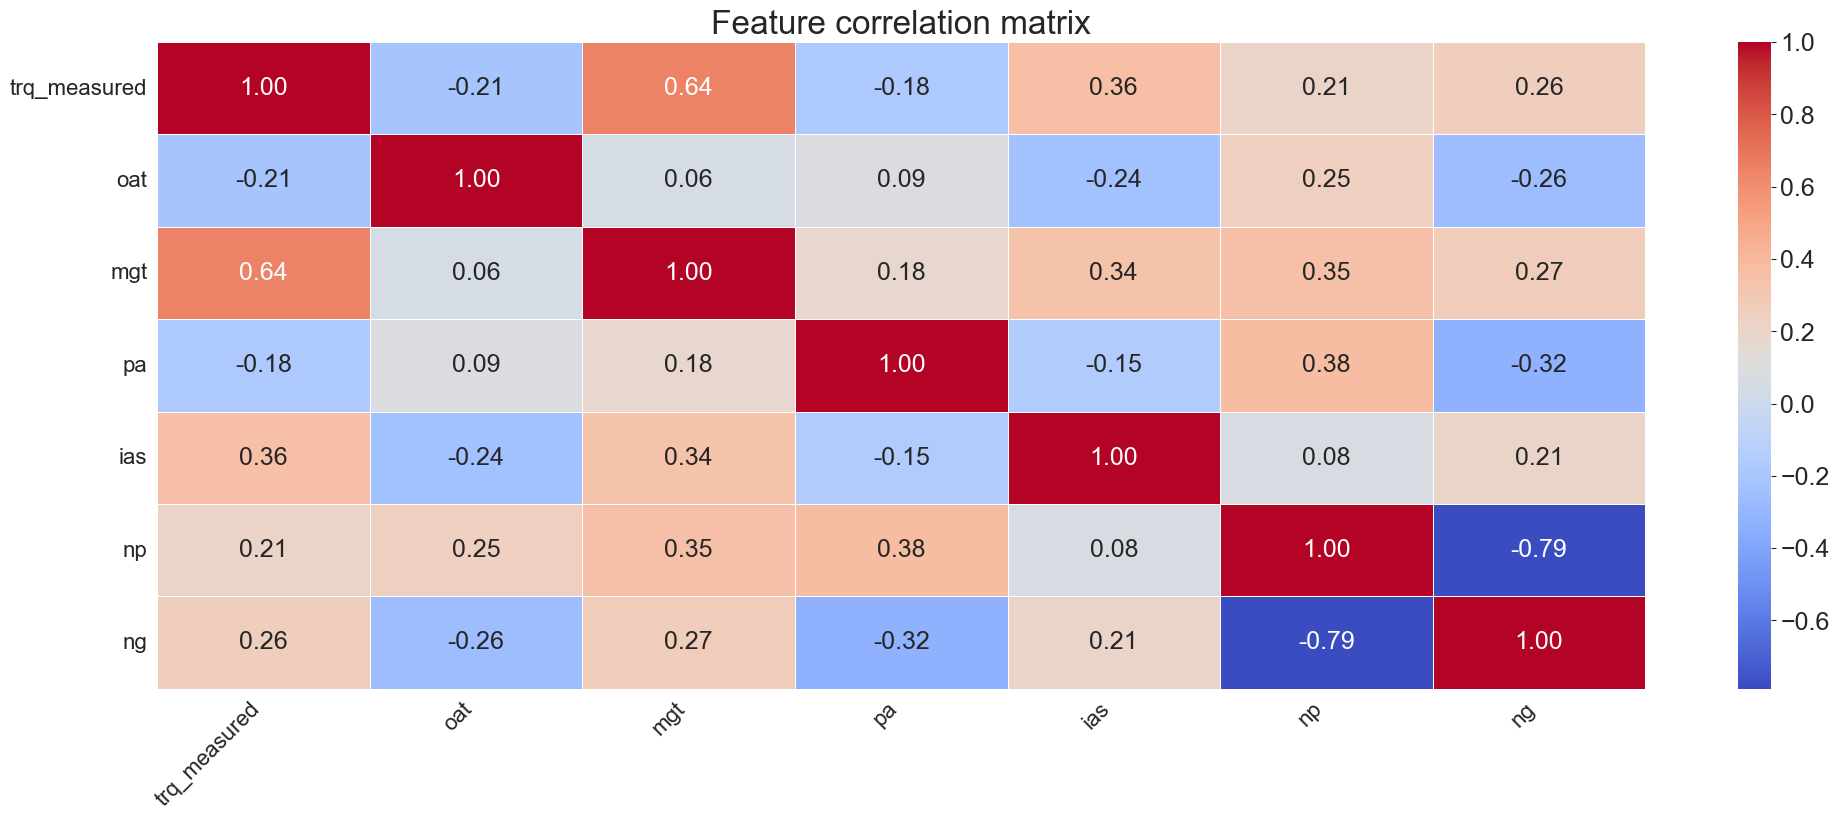

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

### PLOT CORRELATION MATRIX ###
plt.figure(figsize=(24, len(df_x.columns) * 1.2))
corr_matrix = df_x.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)

plt.title("Feature correlation matrix", fontsize=24)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(fontsize=16)

plt.show()


### PCA

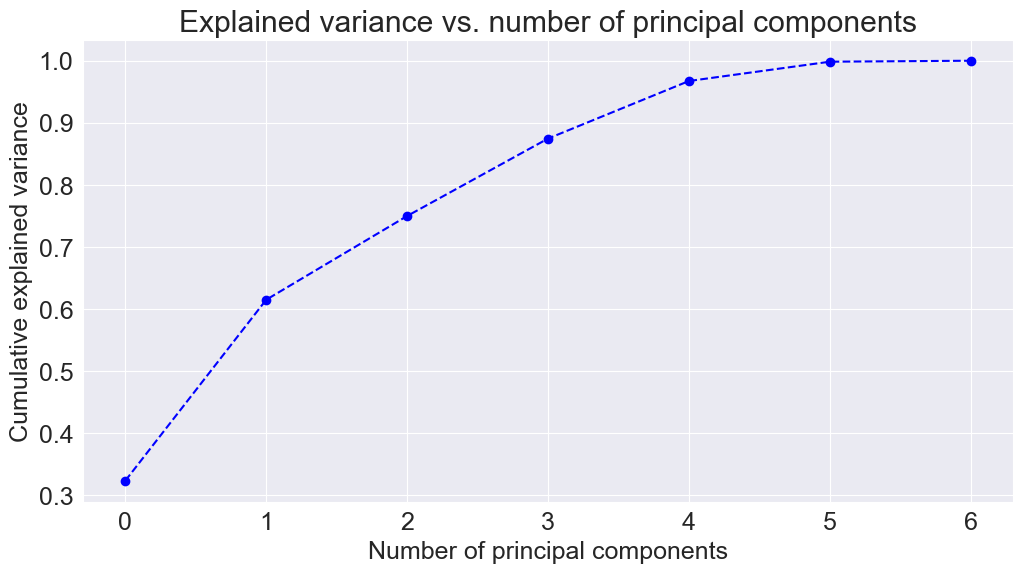

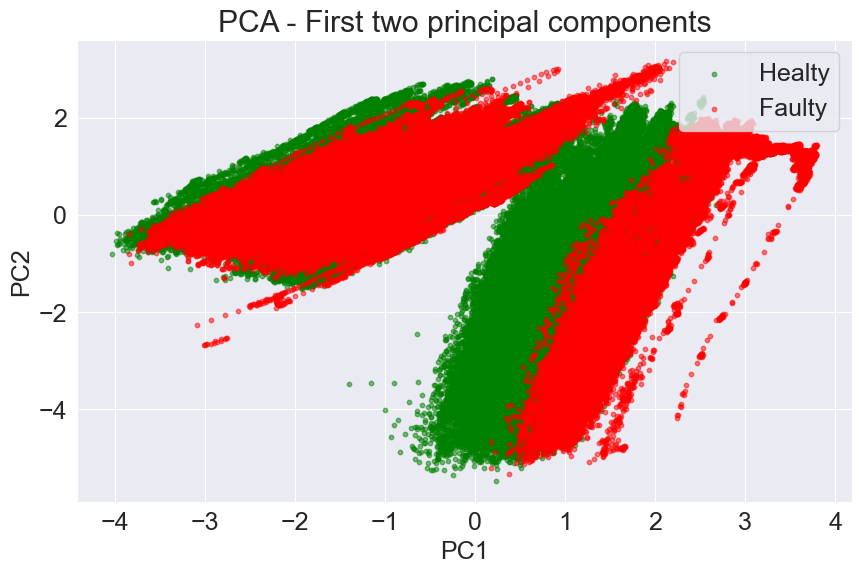

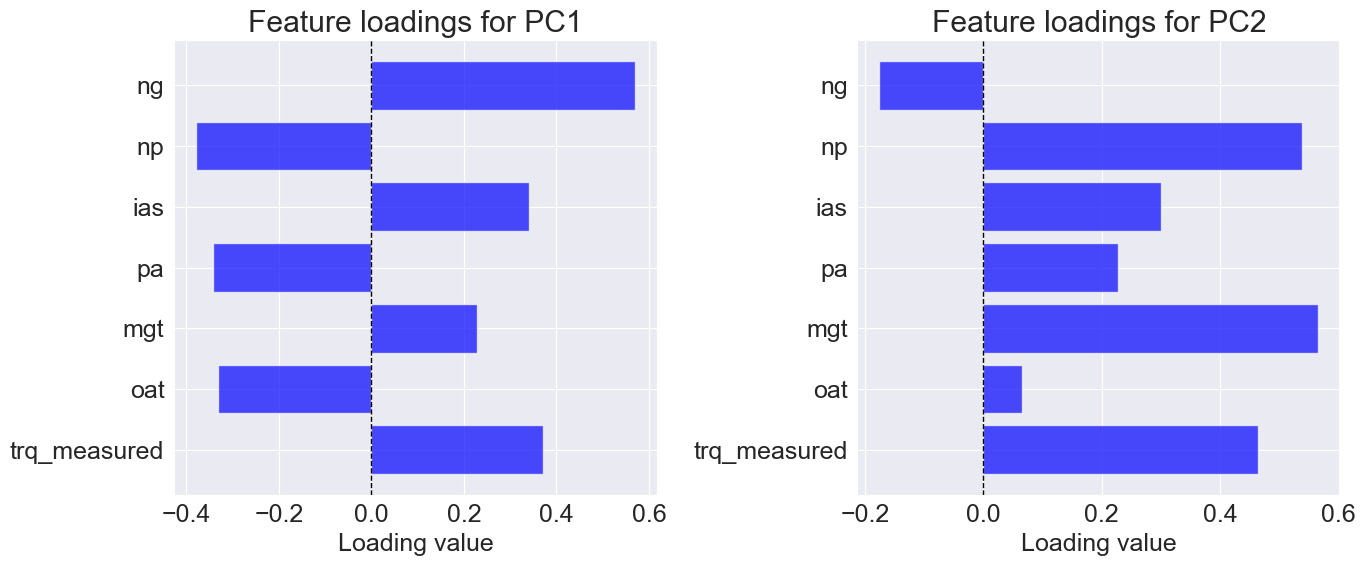

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------
# 1. Standardize df_x for PCA
# ----------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

# ----------------------------------------------------------------------
# 2. Apply PCA
# ----------------------------------------------------------------------
pca = PCA(n_components=len(df_x.columns))  # Keep all components initially
X_pca = pca.fit_transform(X_scaled)

# ----------------------------------------------------------------------
# 3. Plot cumulative explained variance
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs. number of principal components")
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# 4. Scatter plot of first two principal components
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
faulty_labels = df_y['faulty'].values  # Get faulty labels from df_y

# Define colors and labels
colors = {0: 'g', 1: 'r'}
labels = {0: 'Healty', 1: 'Faulty'}

# Scatter plot with legend fix
for label in [0, 1]:
    plt.scatter(
        X_pca[faulty_labels == label, 0],  # PC1
        X_pca[faulty_labels == label, 1],  # PC2
        c=colors[label], label=labels[label], alpha=0.5, s=10  # Reduce point size (s) for large datasets
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - First two principal components")
plt.legend(loc="upper right")  # Fix slow legend
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# 5. Plot PCA Loadings (Feature Contributions)
# ----------------------------------------------------------------------
loadings = pca.components_[:2]  # Take only PC1 and PC2
features = df_x.columns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i, pc in enumerate(["PC1", "PC2"]):
    ax[i].barh(features, loadings[i], color='b', alpha=0.7)
    ax[i].set_title(f"Feature loadings for {pc}")
    ax[i].set_xlabel("Loading value")
    ax[i].axvline(0, color='k', linestyle='--', linewidth=1)  # Vertical line at 0 for reference

plt.tight_layout()
plt.show()


# Dataset sampling: skewness study

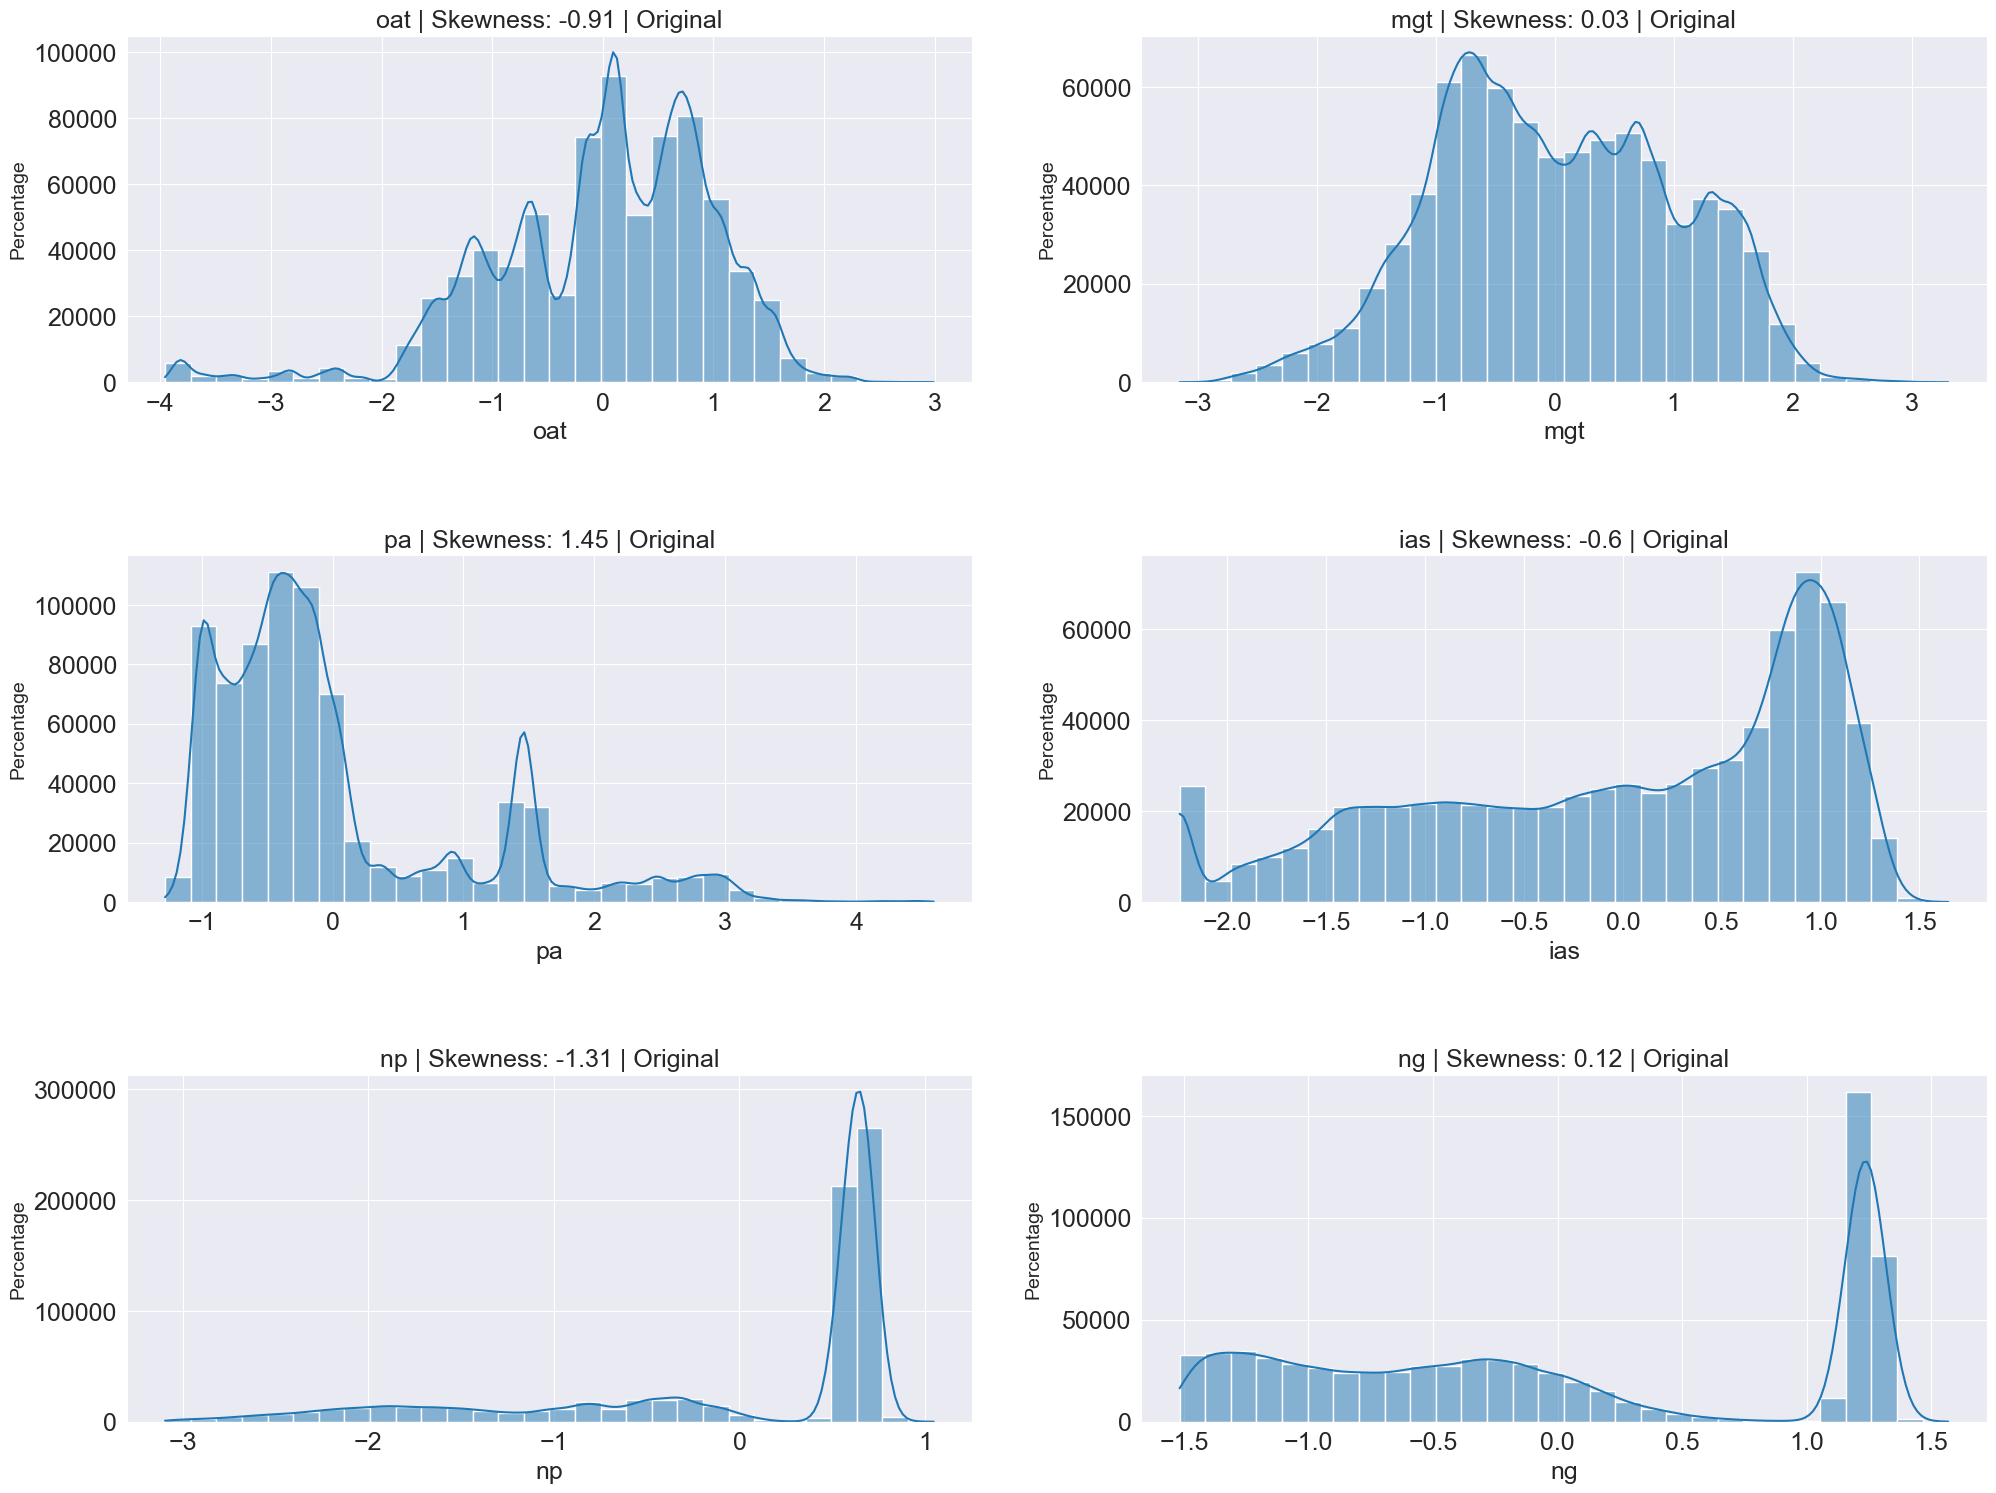

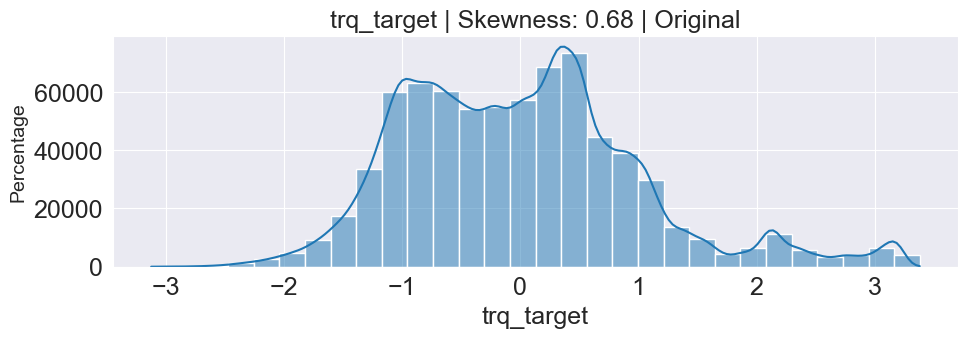

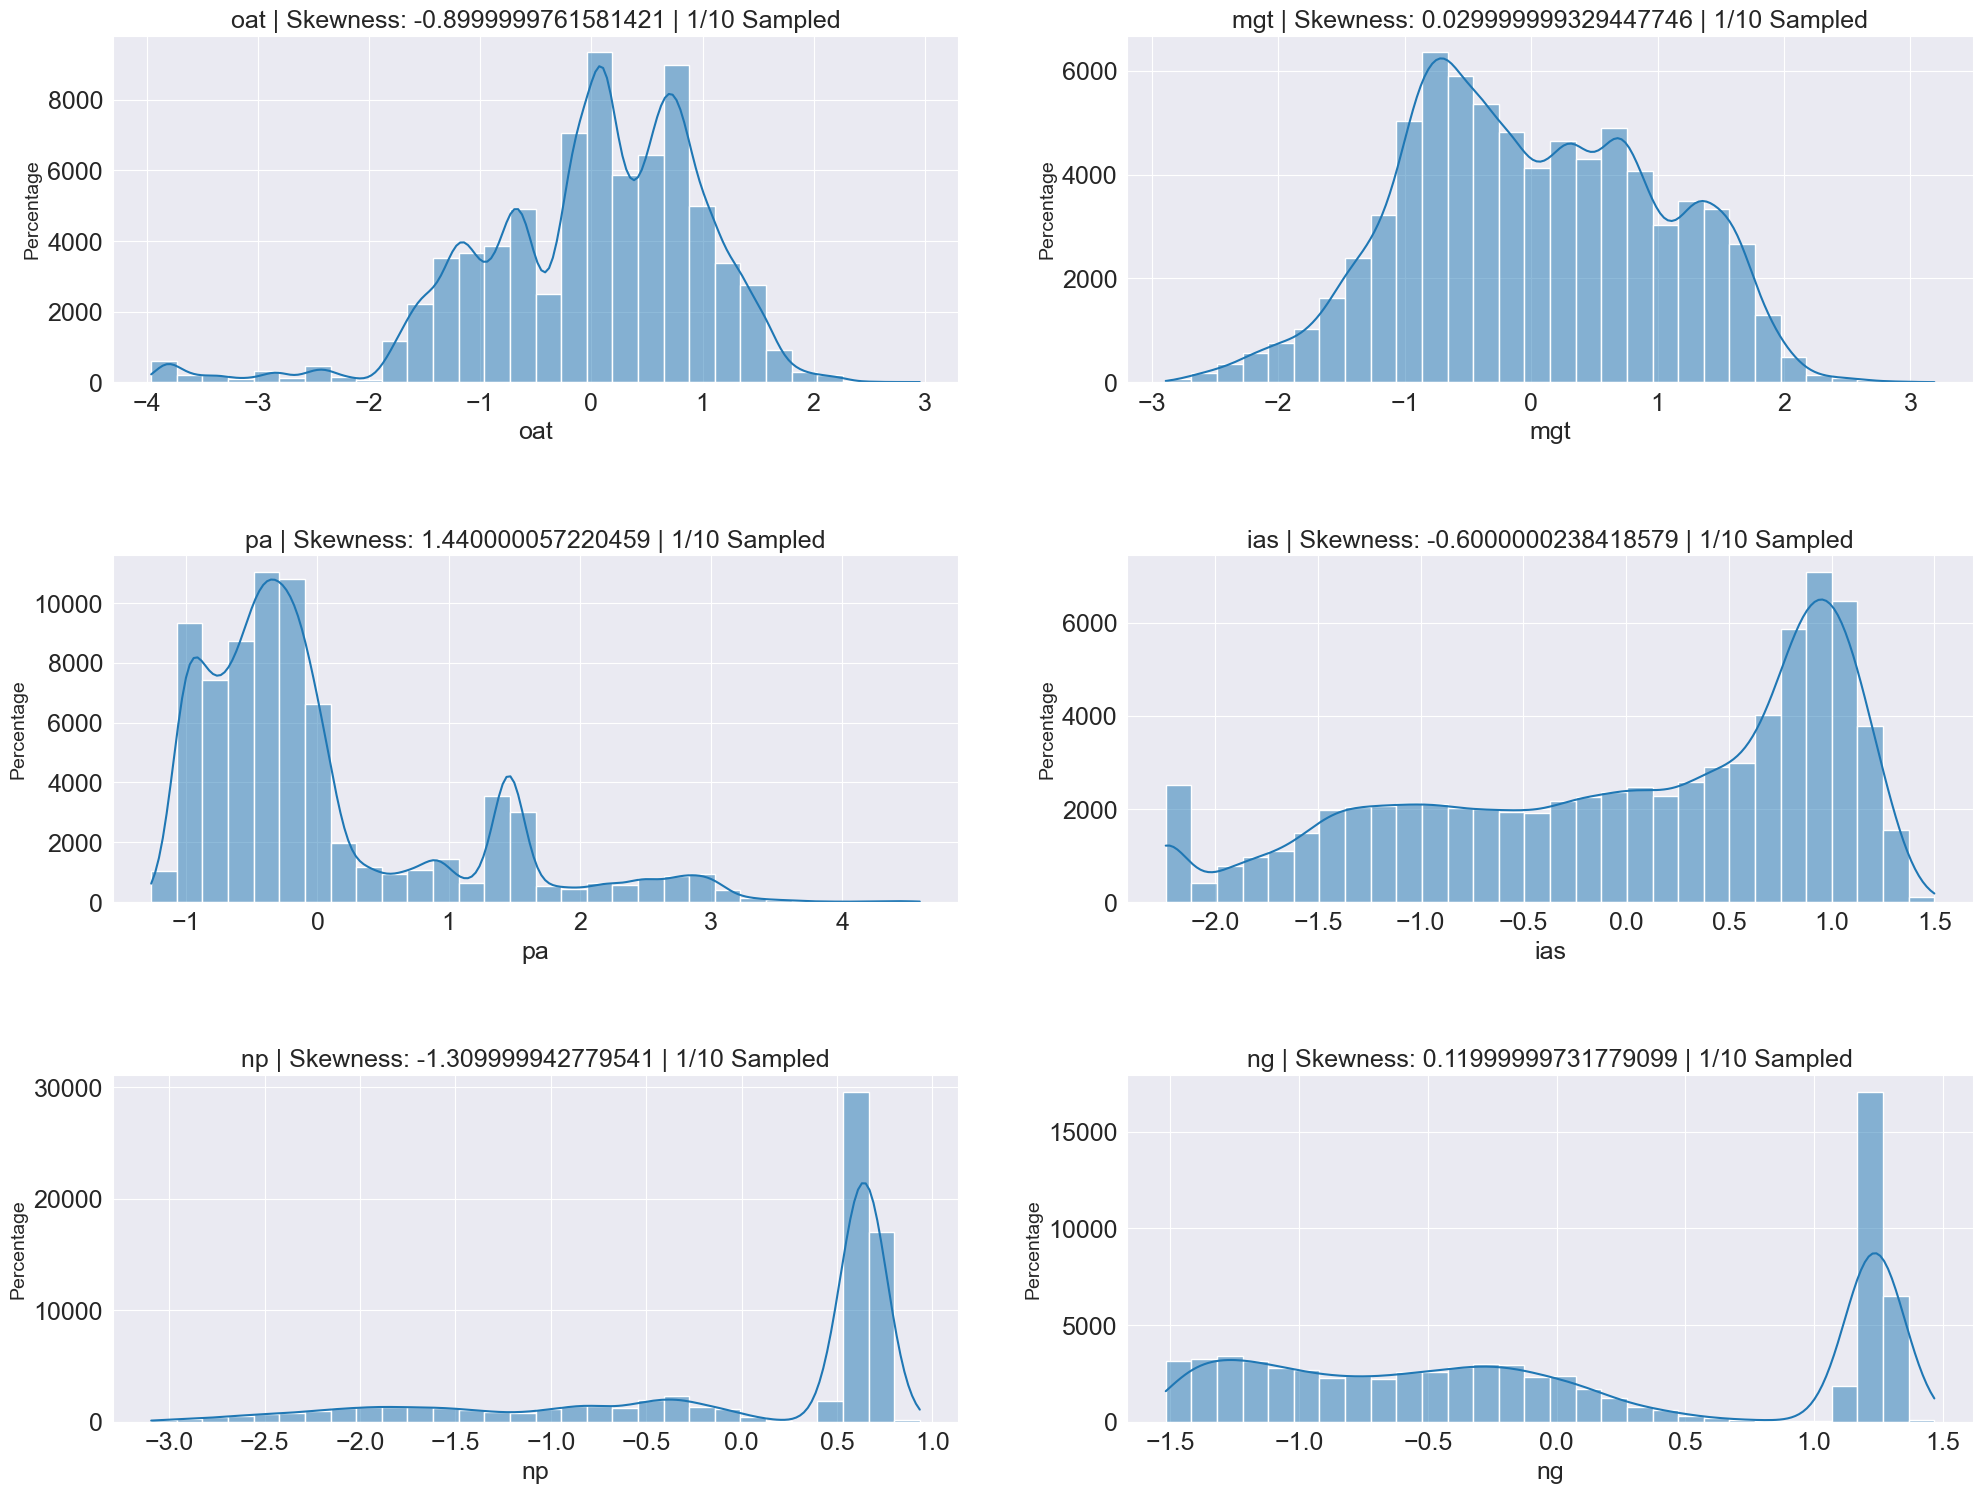

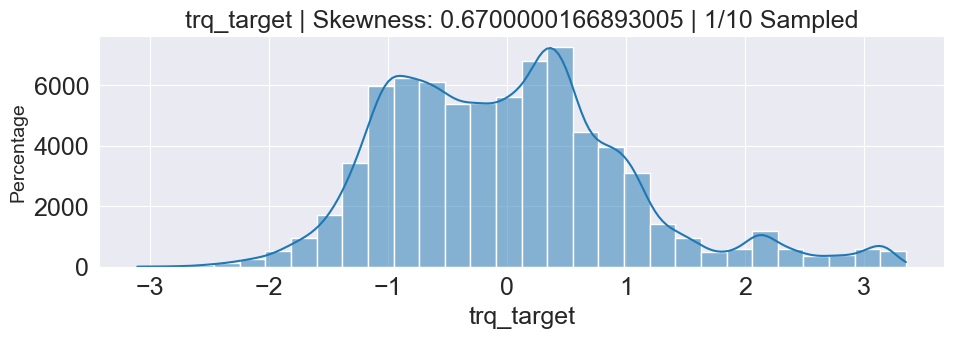

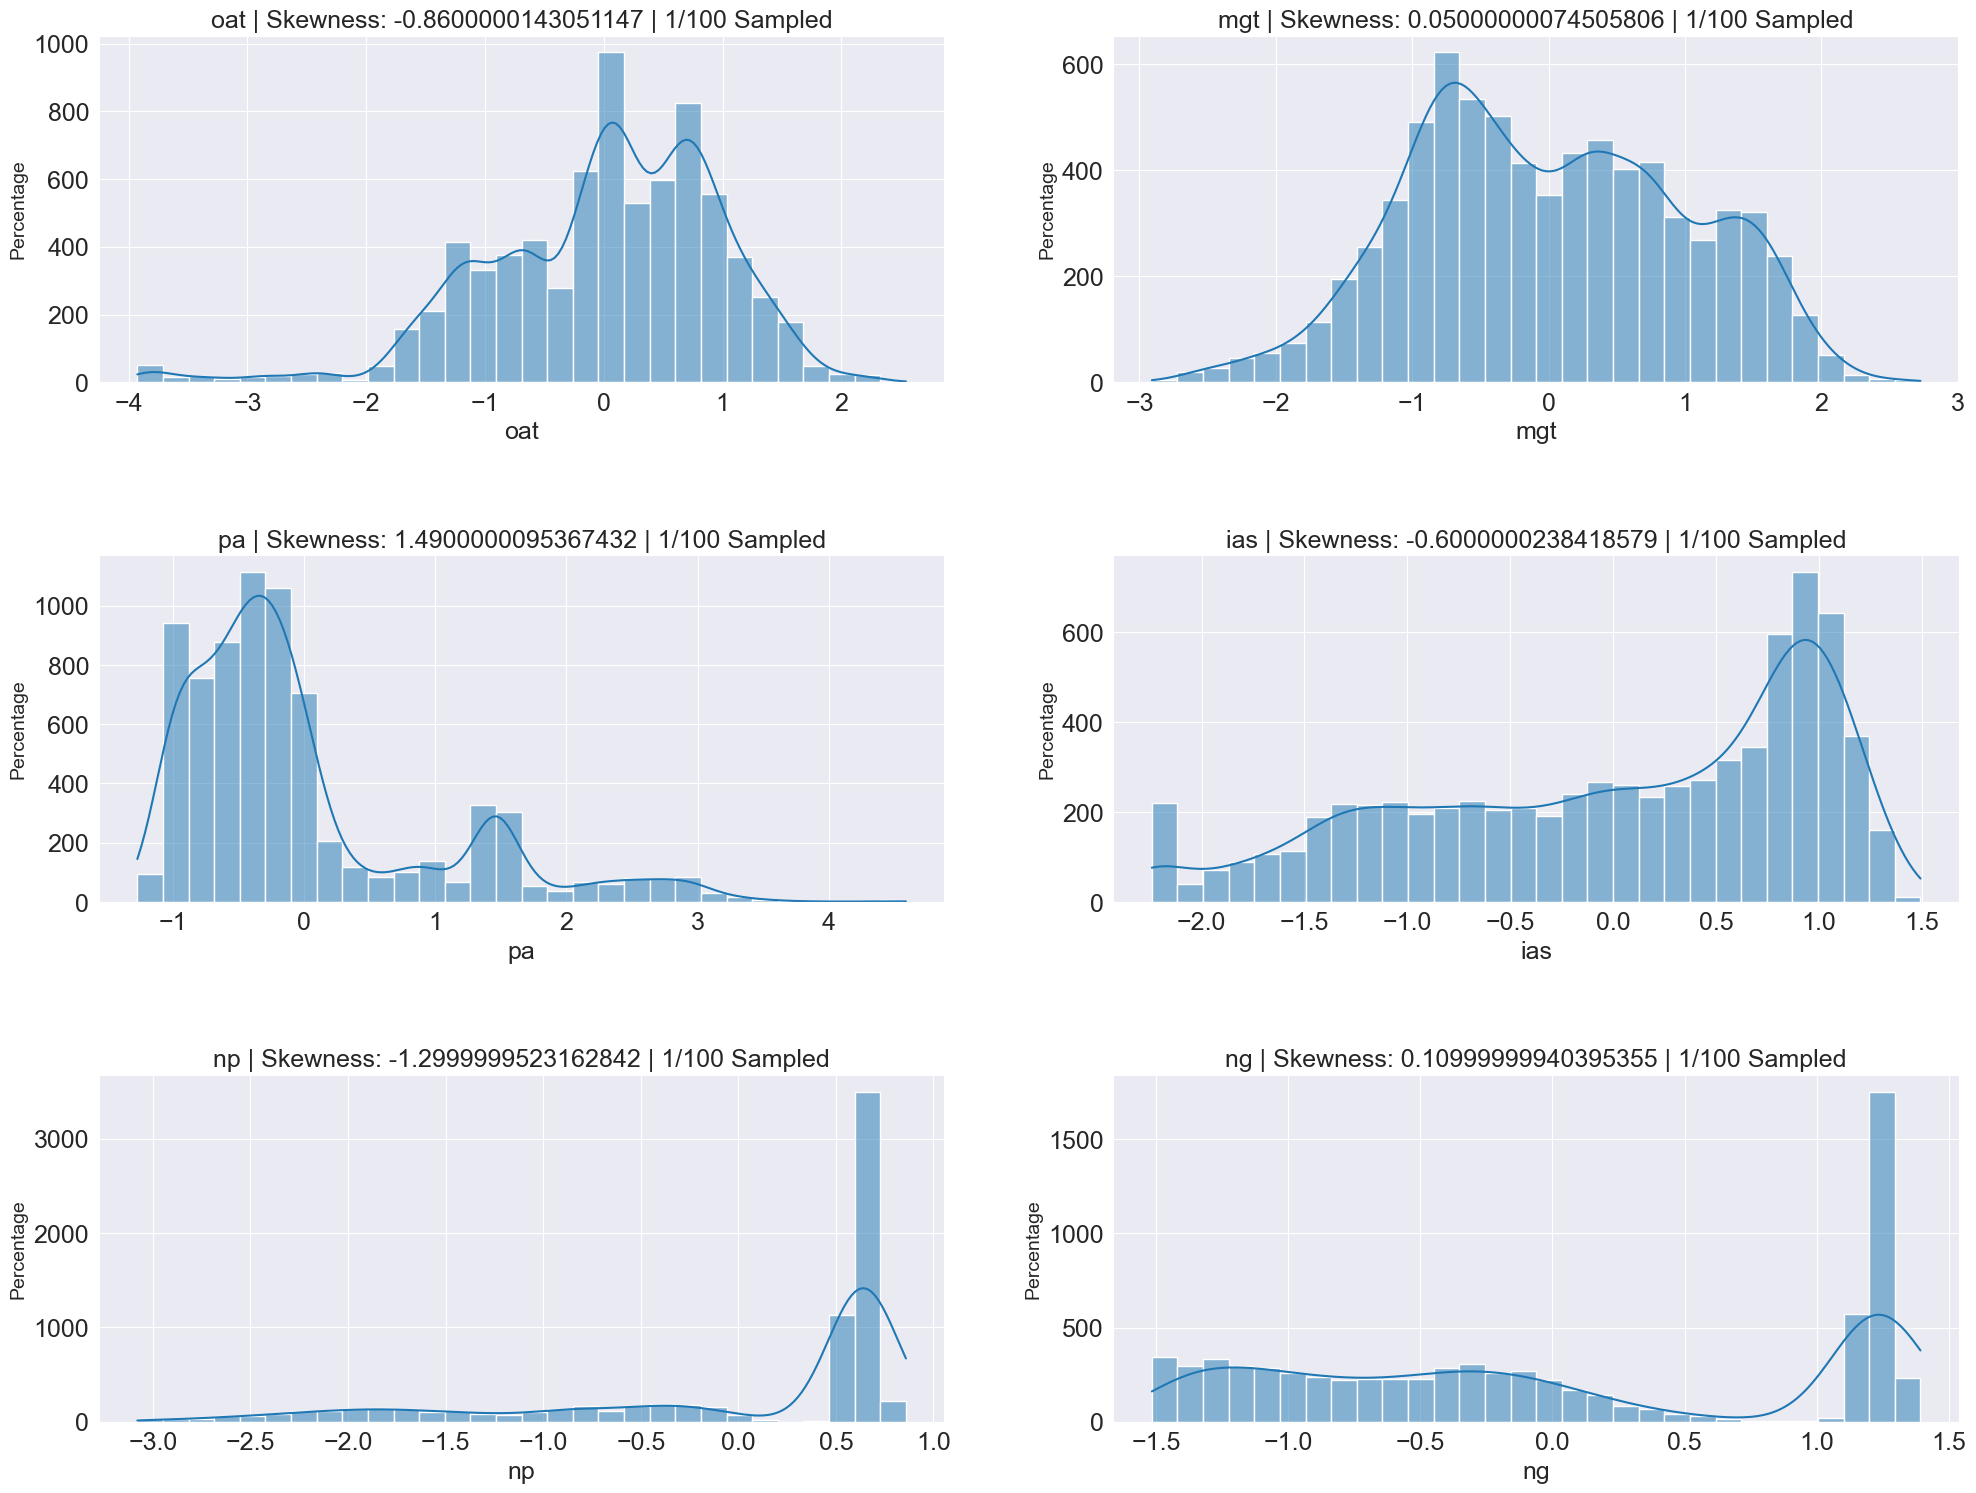

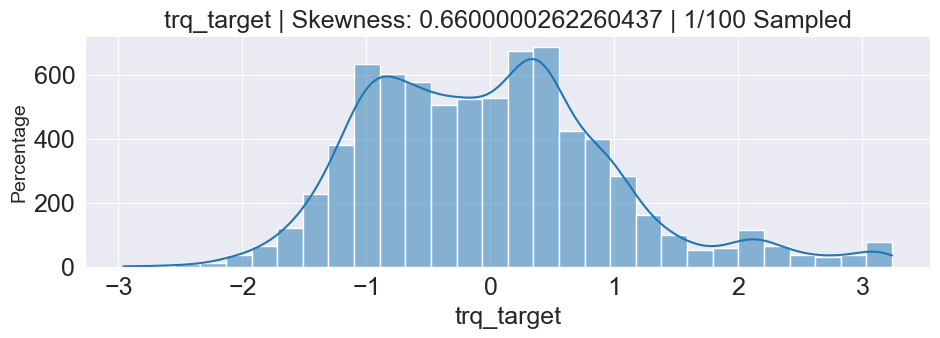

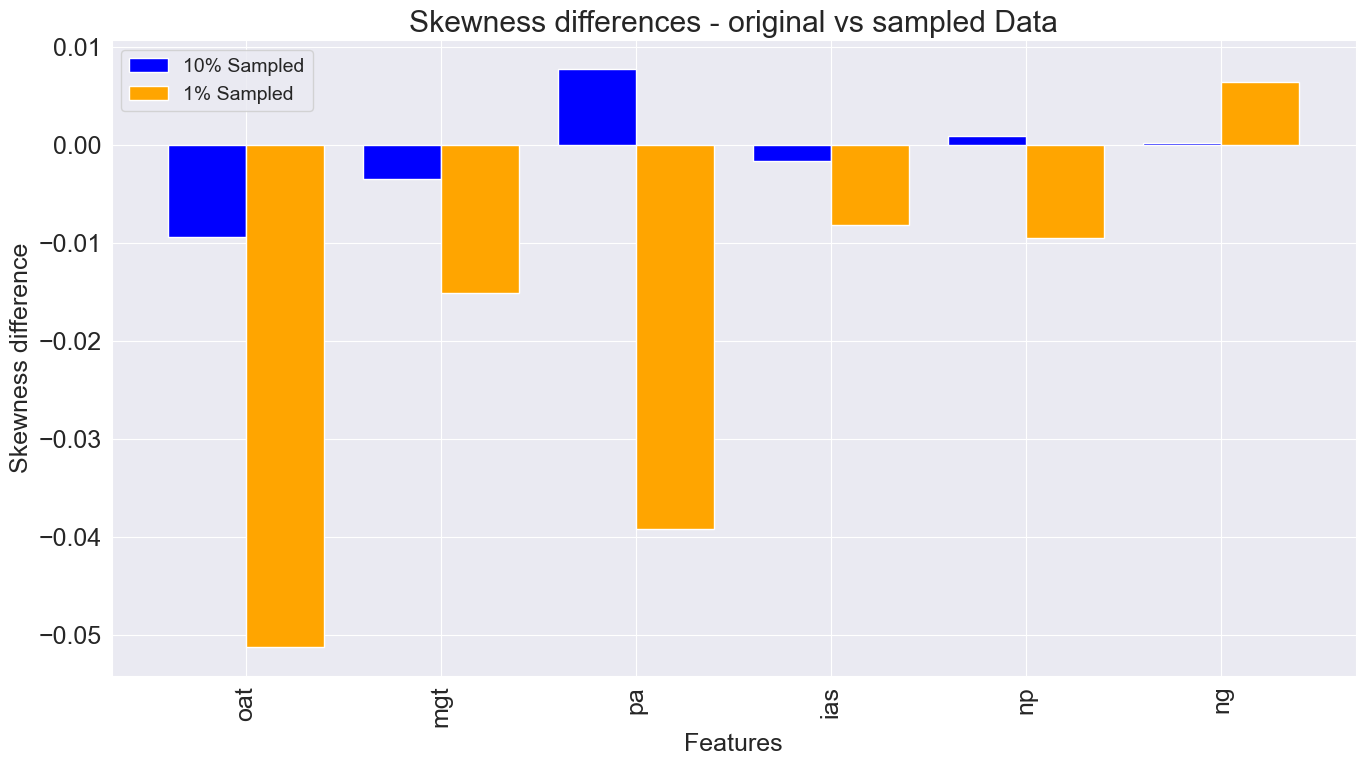

In [43]:
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

df_x = pd.read_csv('../dataset/X_train.csv').drop(columns=['id'])
df_y = pd.read_csv('../dataset/y_train.csv')
df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)

if "faulty" in df_y.columns:
    df_y = df_y.drop(columns=["faulty"])

### NORMALIZE DATA ###
df_x_normalized = (df_x - df_x.mean()) / df_x.std()
df_y_normalized = (df_y['trq_target'] - df_y['trq_target'].mean()) / df_y['trq_target'].std()
df_x_normalized.drop(columns=['trq_measured'], inplace=True)
device = "cpu"
train_x_1 = torch.tensor(df_x_normalized.values, dtype=torch.float32, device=device)
train_y_1 = torch.tensor(df_y_normalized.values, dtype=torch.float32, device=device).unsqueeze(1)
assert train_x_1.shape[0] == train_y_1.shape[0]

### DOWNSAMPLE DATA TO 10% AND 1% OF THE ORIGINAL SIZE ###
np.random.seed(42)
random_indices_10 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 10, replace=False)
train_x_10 = train_x_1[random_indices_10].numpy()
train_y_10 = train_y_1[random_indices_10].numpy()
random_indices_100 = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 100, replace=False)
train_x_100 = train_x_1[random_indices_100].numpy()
train_y_100 = train_y_1[random_indices_100].numpy()

### CONVERT SAMPLED DATA TO DATAFRAMES ###
df_x_10 = pd.DataFrame(train_x_10, columns=df_x_normalized.columns)
df_y_10 = pd.DataFrame(train_y_10, columns=['trq_target'])
df_x_100 = pd.DataFrame(train_x_100, columns=df_x_normalized.columns)
df_y_100 = pd.DataFrame(train_y_100, columns=['trq_target'])

def plot_skewness(df, dataset_type):
    num_features = len(df.columns)
    plt.figure(figsize=(24, num_features * 3))
    for idx, feature in enumerate(df.columns, 1):
        plt.subplot((num_features + 1) // 2, 2, idx)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)} | {dataset_type}", fontsize=18)
        plt.ylabel("Percentage", fontsize=14)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

### PLOT SKEWNESS ###
plot_skewness(df_x_normalized, "Original")
plot_skewness(df_y_normalized.to_frame(), "Original")
plot_skewness(df_x_10, "1/10 Sampled")
plot_skewness(df_y_10, "1/10 Sampled")
plot_skewness(df_x_100, "1/100 Sampled")
plot_skewness(df_y_100, "1/100 Sampled")

### PLOT SKEWNESS DIFFERENCES ###
skew_diff_10 = df_x_normalized.skew() - df_x_10.skew()
skew_diff_100 = df_x_normalized.skew() - df_x_100.skew()

plt.figure(figsize=(14, 8))
features = df_x_normalized.columns
x = np.arange(len(features))

plt.bar(x - 0.2, skew_diff_10, width=0.4, label="10% Sampled", color='blue')
plt.bar(x + 0.2, skew_diff_100, width=0.4, label="1% Sampled", color='orange')

plt.xlabel("Features")
plt.ylabel("Skewness difference")
plt.title("Skewness differences - original vs sampled Data")
plt.xticks(x, features, rotation=90)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


# Feature building

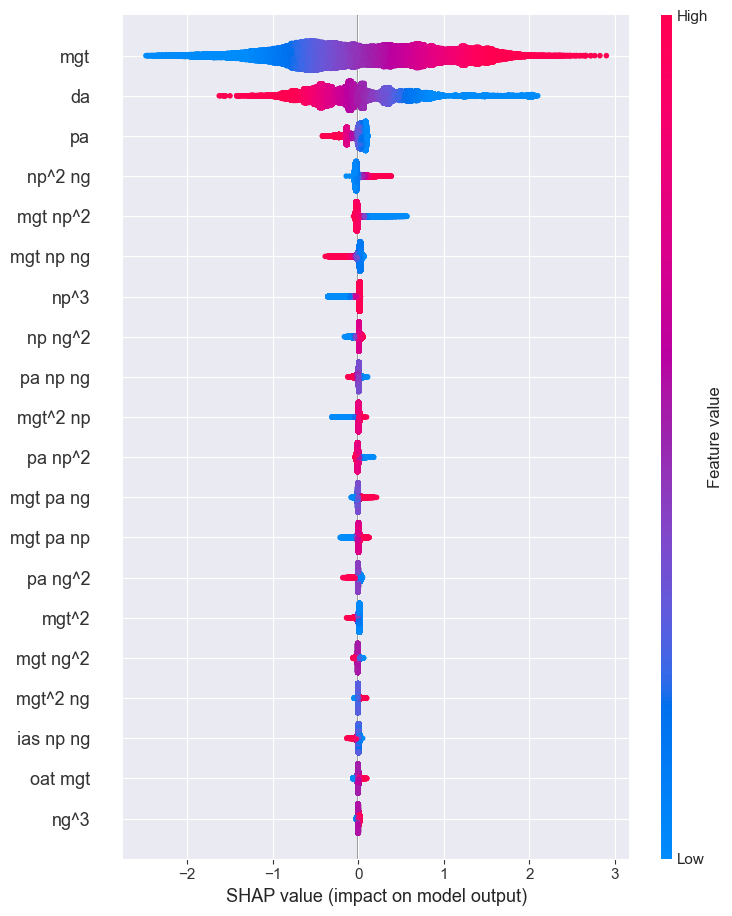

In [ ]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import shap

df_x_10 = pd.DataFrame(train_x_10, columns=df_x_normalized.columns)
df_y_10 = pd.DataFrame(train_y_10, columns=['trq_target'])

### CREATE NEW FEATURES ###

# Add Polynomial Features (degree=N includes features up to N°)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(df_x_10)
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(df_x_10.columns))

# Add NP/NG ratio feature
df_x_10['np_ng_ratio'] = df_x_10['np'] / df_x_10['ng']

# Air density formula: da = 1.2376 * pa + 118.8 * oat - 1782
df_x_10['da'] = (1.2376 * df_x_10['pa']) + (118.8 * df_x_10['oat']) - 1782

df_x_10_new = pd.concat([df_x_10, poly_df], axis=1)
df_x_10_new = df_x_10_new.loc[:, ~df_x_10_new.columns.duplicated()]

### FIT A REGRESSION MODEL AND COMPUTE SHAP VALUES ###
model = LinearRegression()
model.fit(df_x_10_new, df_y_10)
explainer = shap.Explainer(model, df_x_10_new)
shap_values = explainer(df_x_10_new)
# Plot SHAP summary with automatic main features selection
shap.summary_plot(shap_values, df_x_10_new)

In [47]:
### EXPORT PREPROCESSED DATASET TO CSV ###

import os

# Ensure the '../dataset/' folder exists
os.makedirs('../dataset/', exist_ok=True)

# Export df_x_10_new and df_y_10 as CSV in the '../dataset/' folder
df_x_10_new.to_csv('../dataset/X_train_10_new.csv', index=False)
df_y_10.to_csv('../dataset/y_train_10.csv', index=False)